In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
df = pd.read_csv('combined_data.csv')
df.head(3)

,car_links,city,Fuel_Type,Transmission,Owner,OEM,Model,Model_Year,Price,Registration_Year,...,Year_of_Manufacture,Feature_Heading,Top_Features,Category_Heading,Category_SubHeading,Category_Features,Mileage,Engine,Max_Power,Torque
0,https://www.cardekho.com/used-car-details/used...,Bangalore,Petrol,Manual,3rd Owner,Maruti,Maruti Celerio,2015,₹ 4 Lakh,2015,...,2015.0,Features,"Power Steering, Power Windows Front, Air Condi...",Comfort & Convenience,Comfort,"Power Steering, Power Windows Front, Power Win...",23.1 kmpl,998 CC,67.04bhp,90Nm
1,https://www.cardekho.com/buy-used-car-details/...,Bangalore,Petrol,Manual,2nd Owner,Ford,Ford Ecosport,2018,₹ 8.11 Lakh,Feb 2018,...,2018.0,Features,"Power Steering, Power Windows Front, Air Condi...",Comfort & Convenience,Comfort,"Power Steering, Power Windows Front, Power Win...",17 kmpl,1497 CC,121.31bhp,150Nm
2,https://www.cardekho.com/used-car-details/used...,Bangalore,Petrol,Manual,1st Owner,Tata,Tata Tiago,2018,₹ 5.85 Lakh,Sept 2018,...,2018.0,Features,"Power Steering, Power Windows Front, Air Condi...",Comfort & Convenience,Comfort,"Power Steering, Power Windows Front, Power Win...",23.84 kmpl,1199 CC,84bhp,114Nm


In [4]:
df.shape

(8369, 26)

In [5]:
print(df['Category_Heading'].unique())
print(df['Category_SubHeading'].unique())
print(df['Feature_Heading'].unique())

['Comfort & Convenience' nan 'Exterior' 'Interior']
['Comfort' nan 'Exterior' 'Interior']
['Features']


In [6]:
df.columns

Index(['car_links', 'city', 'Fuel_Type', 'Transmission', 'Owner', 'OEM',
       'Model', 'Model_Year', 'Price', 'Registration_Year',
       'Insurance_Validity', 'Seats', 'Kms_Driven', 'RTO', 'Ownership',
       'Engine_Displacement', 'Year_of_Manufacture', 'Feature_Heading',
       'Top_Features', 'Category_Heading', 'Category_SubHeading',
       'Category_Features', 'Mileage', 'Engine', 'Max_Power', 'Torque'],
      dtype='object')

In [7]:
# dropping the column that are not useful in prediction
# Registration year, Year_of_Manufacture, and model year columns are redundant. similarly owner and ownership columns are redudant.similarly engine
# and engine_displacement columns are redundant

columns_to_drop = ['car_links','Registration_Year','Year_of_Manufacture','Category_Heading','Category_SubHeading','Feature_Heading','Category_Features',
                   'Owner','Engine_Displacement','RTO','Insurance_Validity','Torque']
df_1 = df.drop(columns=columns_to_drop)

In [8]:
df_1.isnull().sum()

city              0
Fuel_Type         0
Transmission      0
OEM               0
Model             0
Model_Year        0
Price             0
Seats             6
Kms_Driven        2
Ownership        32
Top_Features     65
Mileage         287
Engine            4
Max_Power        60
dtype: int64

In [9]:
# many of the columns alphanumeric values. lets process them
import re
# Convert 'Price' column to string
df_1['Price'] = df_1['Price'].astype(str)

# Define a function to extract numeric values, including lakhs or crores

def extract_numeric_price(text):
    match = re.search(r'₹\s*([\d,]+\.?\d*)\s*(Lakh|Crore)?', text)
    if match:
        value_str, unit = match.groups()
        value_str = value_str.replace(',', '')
        try:
            value = float(value_str)
            if unit == 'Lakh':
                value *= 1e5
            elif unit == 'Crore':
                value *= 1e7
            return value
        except ValueError:
            print(f"Unable to convert value to float: {value_str}")
    else:
        print(f"No match found for: {text}")
    return None


df_1['Price'] = df_1['Price'].apply(extract_numeric_price)
df_1['Kms_Driven'] = df_1['Kms_Driven'].str.replace(',', '').str.extract('(\d+)').astype(float)
df_1['Mileage(kmpl)'] = pd.to_numeric(df_1['Mileage'].str.replace('kmpl', '').str.replace('km/kg', ''), errors = 'coerce')
df_1['Max_Power(bhp)'] = pd.to_numeric(df_1['Max_Power'].str.replace('bhp', ''), errors='coerce')
df_1['Engine(CC)'] = pd.to_numeric(df_1['Engine'].str.replace('CC', ''), errors='coerce')\



In [10]:
df_1.head(2)

,city,Fuel_Type,Transmission,OEM,Model,Model_Year,Price,Seats,Kms_Driven,Ownership,Top_Features,Mileage,Engine,Max_Power,Mileage(kmpl),Max_Power(bhp),Engine(CC)
0,Bangalore,Petrol,Manual,Maruti,Maruti Celerio,2015,400000.0,5.0,120000.0,Third Owner,"Power Steering, Power Windows Front, Air Condi...",23.1 kmpl,998 CC,67.04bhp,23.1,67.04,998.0
1,Bangalore,Petrol,Manual,Ford,Ford Ecosport,2018,811000.0,5.0,32706.0,Second Owner,"Power Steering, Power Windows Front, Air Condi...",17 kmpl,1497 CC,121.31bhp,17.0,121.31,1497.0


In [11]:
df_1.isnull().sum()

city                0
Fuel_Type           0
Transmission        0
OEM                 0
Model               0
Model_Year          0
Price               0
Seats               6
Kms_Driven          2
Ownership          32
Top_Features       65
Mileage           287
Engine              4
Max_Power          60
Mileage(kmpl)     287
Max_Power(bhp)    246
Engine(CC)          4
dtype: int64

In [12]:
df_1 = df_1.dropna()

In [122]:
# drop duplicate columns
duplicate_columns = ['Mileage','Engine','Max_Power']
df_final = df_1.drop(columns=duplicate_columns)

In [123]:
# Assuming your 'Top_Features' column is a string
df_final['Top_Features'] = df_final['Top_Features'].str.split(', ')

# Create a new column with a string of the top three features
df_final['Top_3_Features'] = df_final['Top_Features'].apply(lambda features_list: ', '.join(features_list[:3]) if features_list else '')

# Drop the original 'Top_Features' column if needed
df_final.drop('Top_Features', axis=1, inplace=True)


In [124]:
df_final['Top_3_Features'].nunique()

41

In [125]:
df_final.dtypes

city               object
Fuel_Type          object
Transmission       object
OEM                object
Model              object
Model_Year          int64
Price             float64
Seats             float64
Kms_Driven        float64
Ownership          object
Mileage(kmpl)     float64
Max_Power(bhp)    float64
Engine(CC)        float64
Top_3_Features     object
dtype: object

In [15]:
df_final.describe()

,Model_Year,Price,Seats,Kms_Driven,Mileage(kmpl),Max_Power(bhp),Engine(CC)
count,7819.000000,7.819000e+03,7819.000000,7.819000e+03,7819.000000,7819.000000,7819.000000
mean,2016.597775,9.092861e+05,5.200665,5.906469e+04,19.320616,103.809762,1416.457347
std,3.621127,1.166478e+06,0.653440,7.470413e+04,3.911237,44.603777,465.091860
min,1985.000000,2.800000e+04,2.000000,1.010000e+02,7.080000,34.200000,72.000000
25%,2014.000000,4.000000e+05,5.000000,3.146350e+04,17.030000,78.850000,1197.000000
50%,2017.000000,6.000000e+05,5.000000,5.398200e+04,19.010000,88.500000,1199.000000
75%,2019.000000,9.095000e+05,5.000000,8.000000e+04,21.630000,118.350000,1498.000000
max,2023.000000,2.600000e+07,10.000000,5.500000e+06,140.000000,510.000000,5000.000000


# Exploratory Data Analysis

<Figure size 1000x800 with 0 Axes>

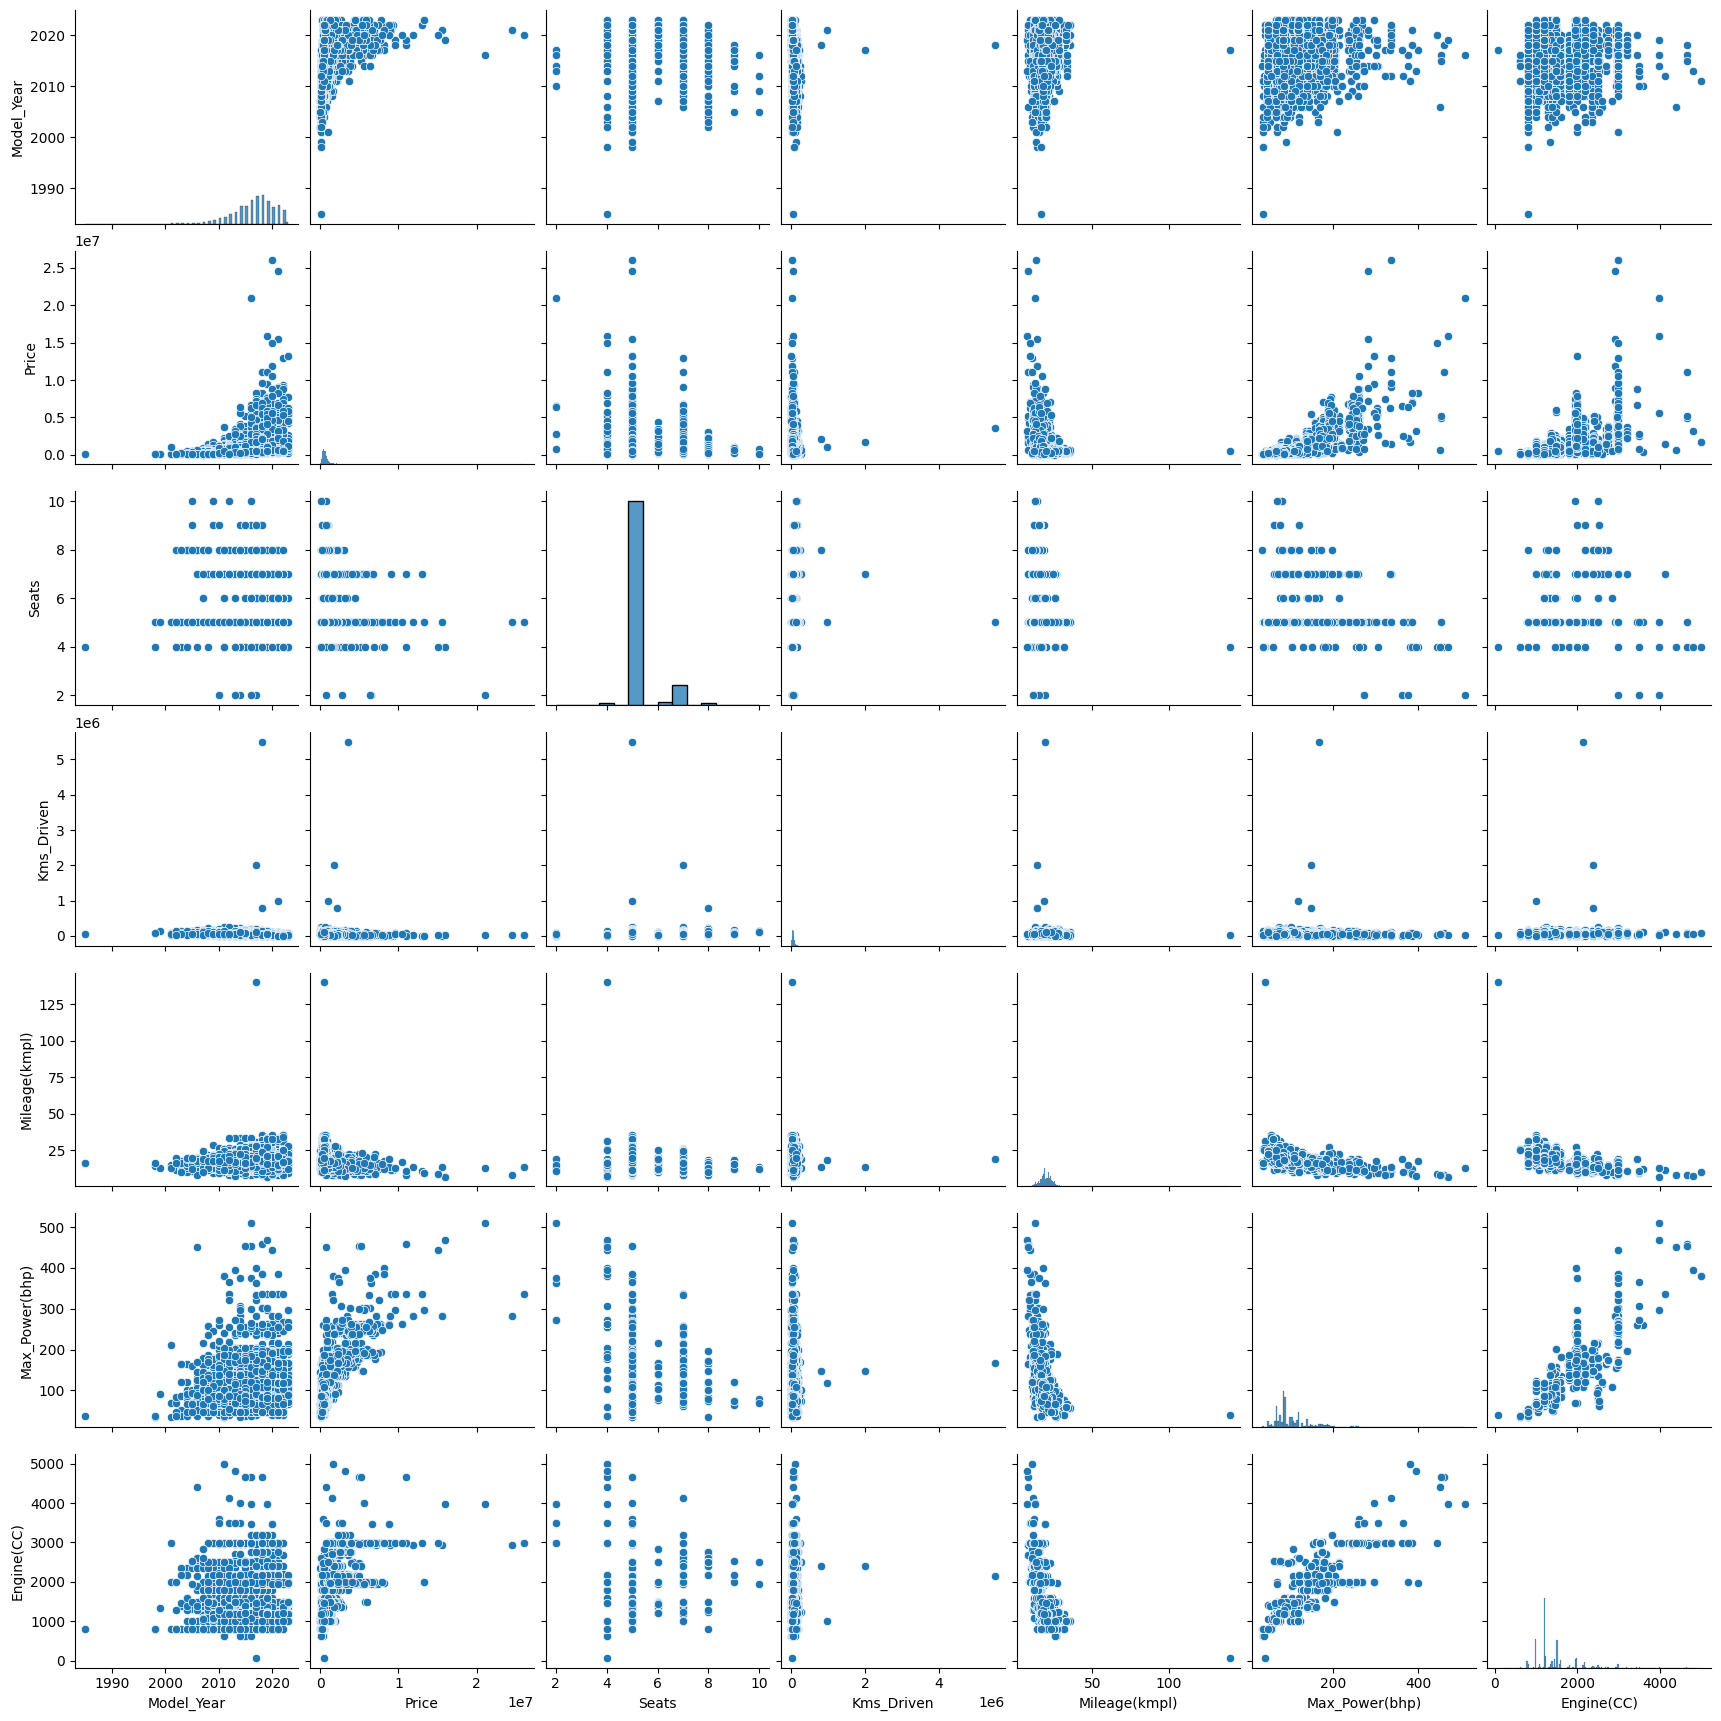

In [59]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

numeric_columns = ['Model_Year', 'Price', 'Seats', 'Kms_Driven', 'Mileage(kmpl)', 'Max_Power(bhp)', 'Engine(CC)']

plt.figure(figsize=(10, 8))
sns.pairplot(data=df_final[numeric_columns])
plt.show()


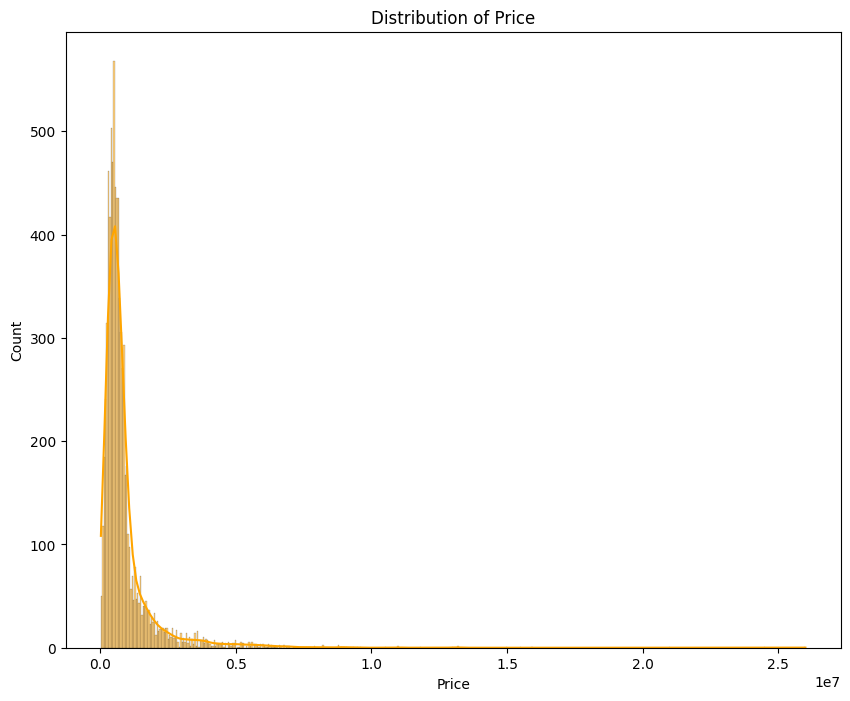

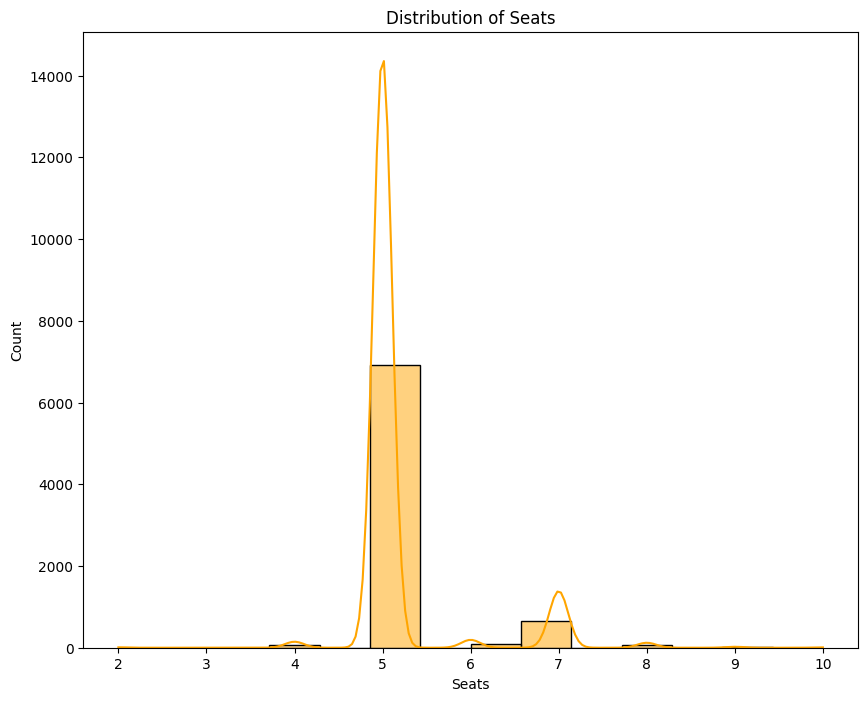

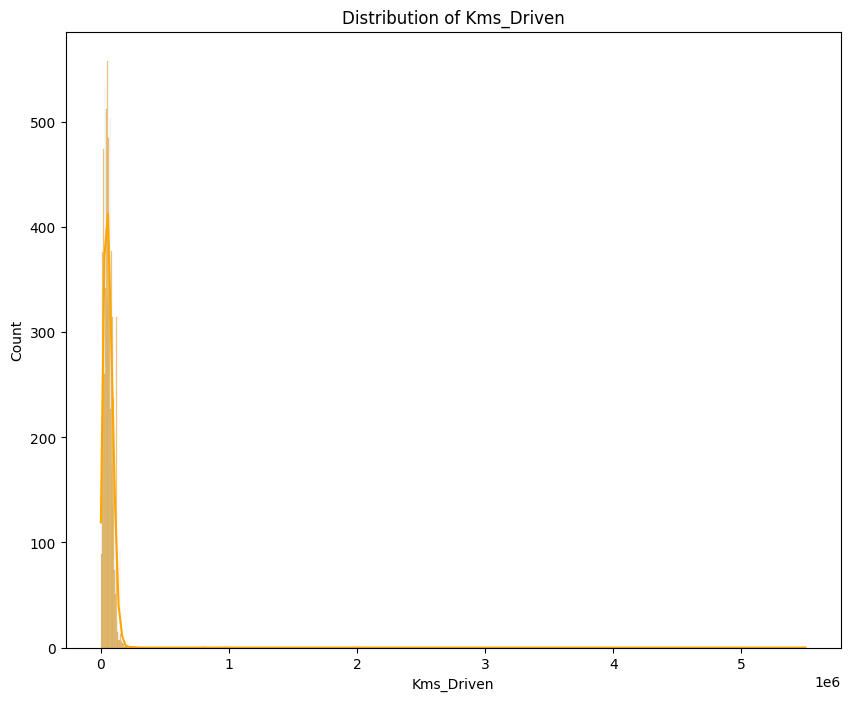

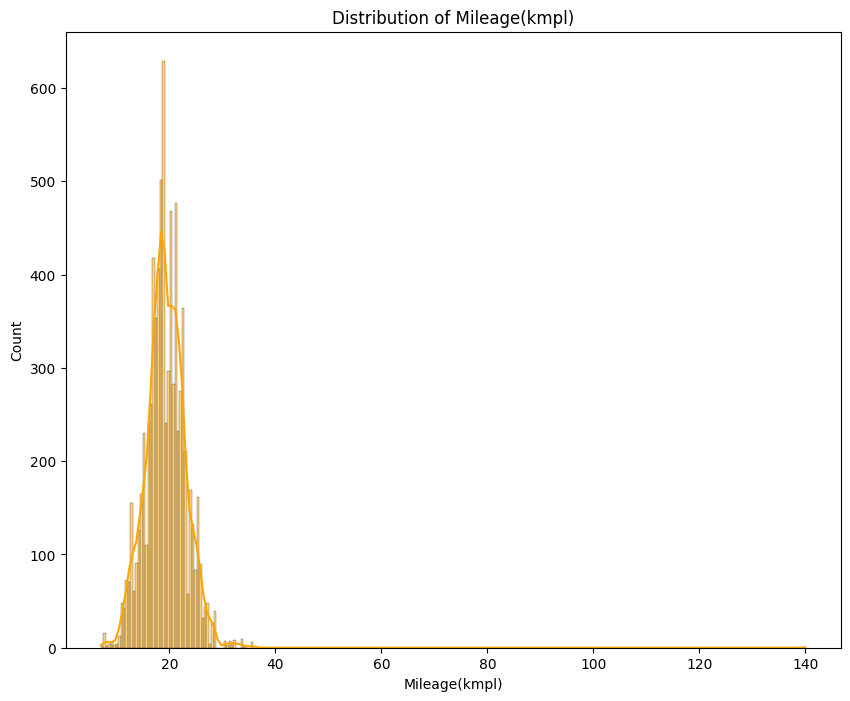

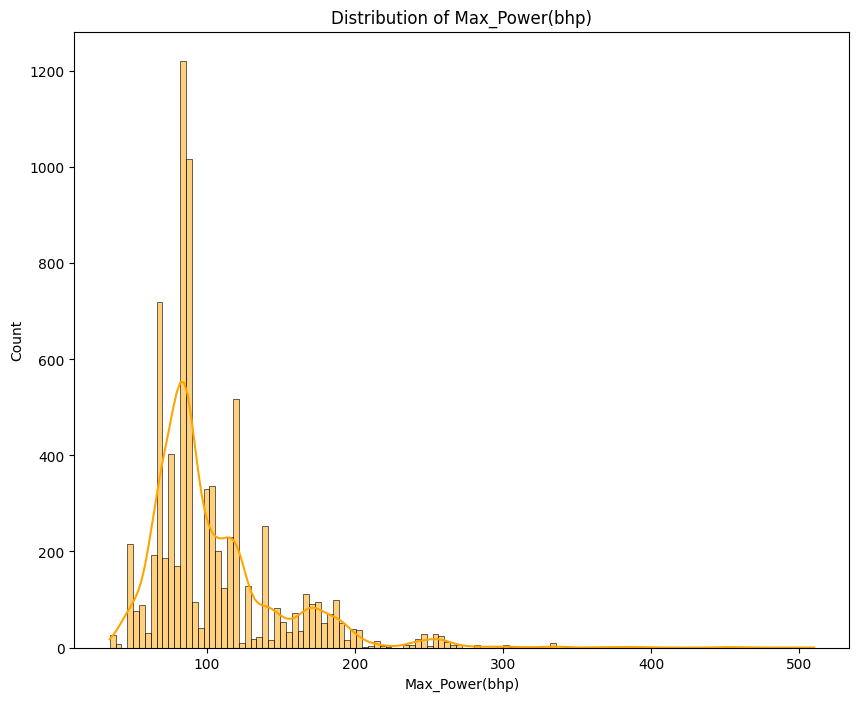

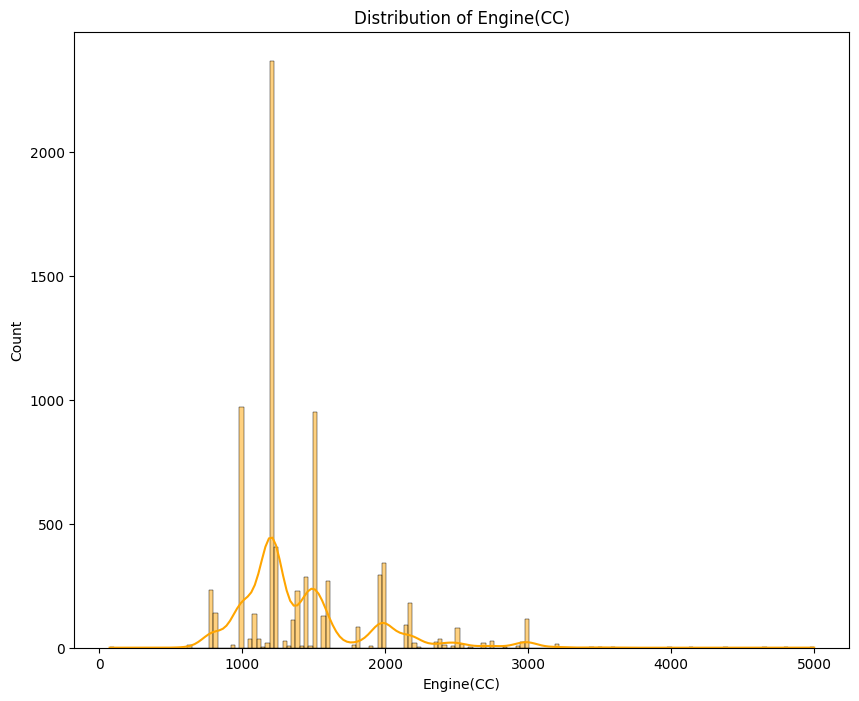

In [64]:
numeric_columns = ['Price', 'Seats', 'Kms_Driven', 'Mileage(kmpl)', 'Max_Power(bhp)', 'Engine(CC)']
for col in numeric_columns:
    plt.figure(figsize=(10,8))
    sns.histplot(df_final[col],kde=True, color='orange')
    plt.title(f'Distribution of {col}')
    plt.show()


C:\Users\acer\AppData\Local\Temp\ipykernel_17588\2573459073.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df_final, palette='husl')


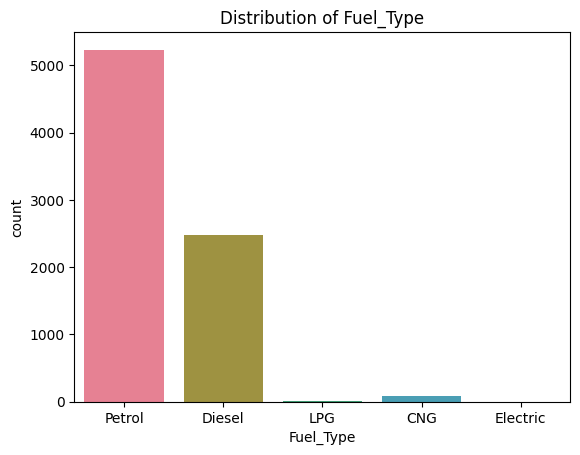

C:\Users\acer\AppData\Local\Temp\ipykernel_17588\2573459073.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df_final, palette='husl')


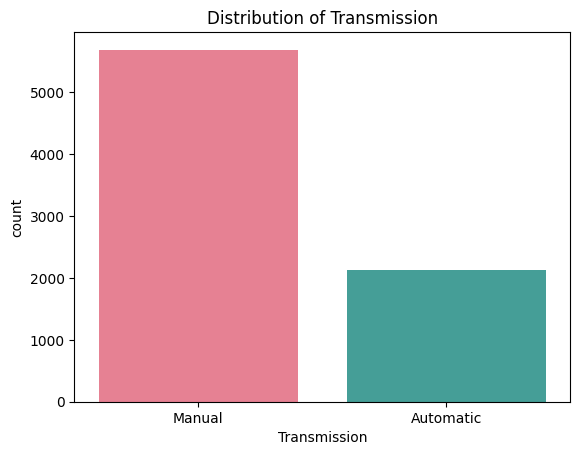

C:\Users\acer\AppData\Local\Temp\ipykernel_17588\2573459073.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df_final, palette='husl')


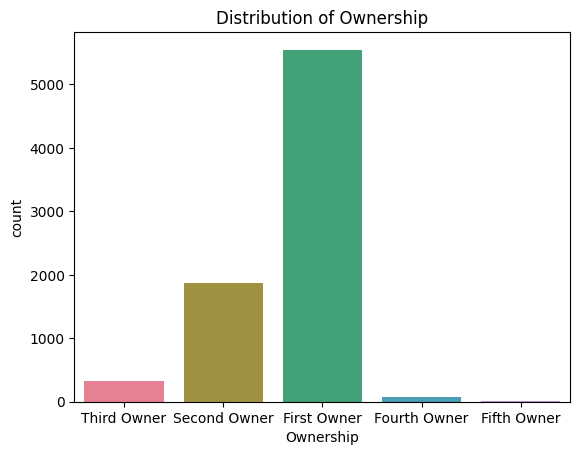

In [25]:
categorical_columns = ['Fuel_Type', 'Transmission', 'Ownership']
for col in categorical_columns:
    sns.countplot(x=col, data=df_final, palette='husl')
    plt.title(f'Distribution of {col}')
    plt.show()


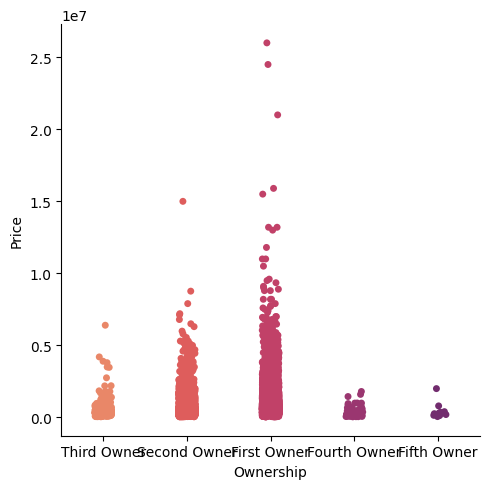

<Figure size 1000x800 with 0 Axes>

In [23]:
sns.catplot(data=df_final, x='Ownership', y='Price', hue='Ownership', palette='flare')
plt.figure(figsize=(10,8))
plt.show()

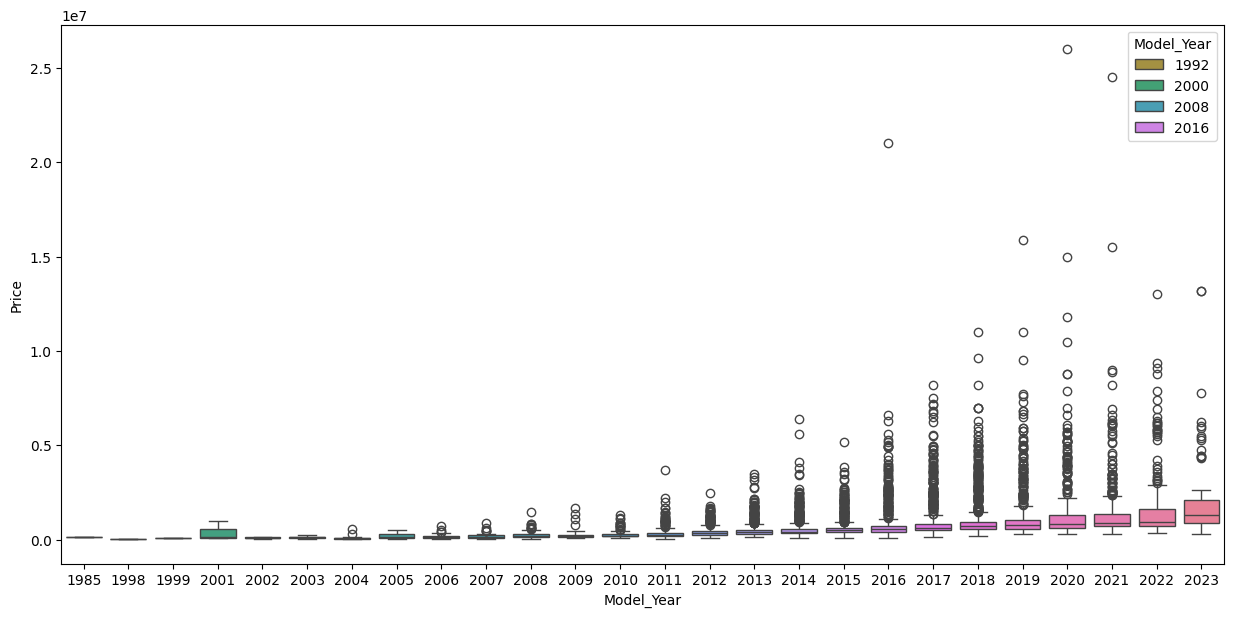

In [39]:
plt.figure(figsize=(15,7))
sns.boxplot(data=df_final, x='Model_Year', y='Price', hue='Model_Year', palette='husl')
plt.show()

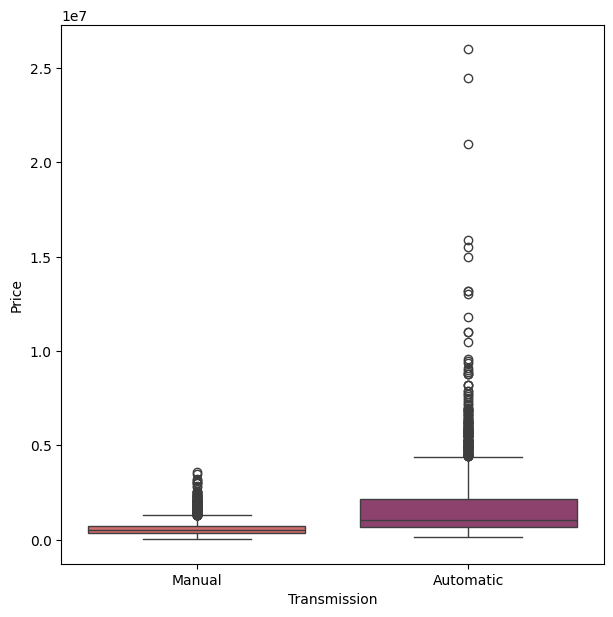

In [43]:
plt.figure(figsize=(7,7))
sns.boxplot(data=df_final, x='Transmission', y='Price', hue='Transmission', palette='flare')
plt.show()

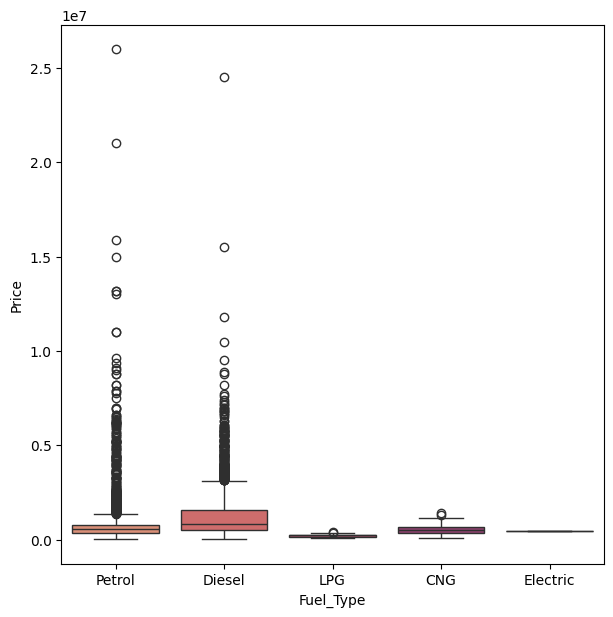

In [46]:
plt.figure(figsize=(7,7))
sns.boxplot(data=df_final, x='Fuel_Type', y='Price', hue='Fuel_Type', palette='flare')
plt.show()

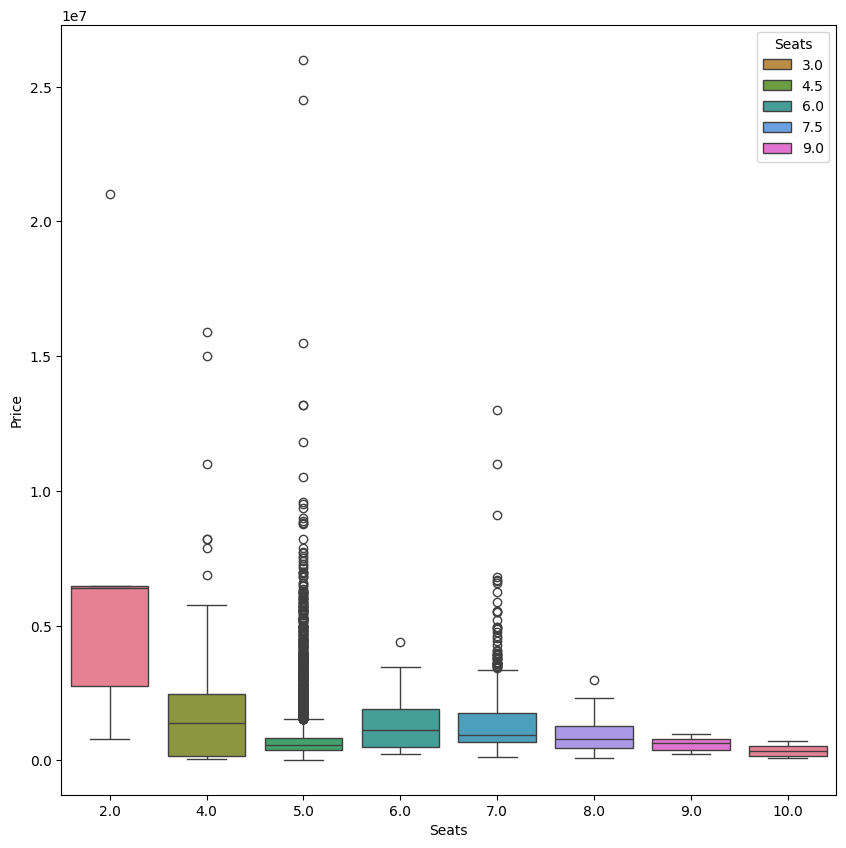

In [44]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df_final, x='Seats', y='Price', hue='Seats', palette='husl')
plt.show()

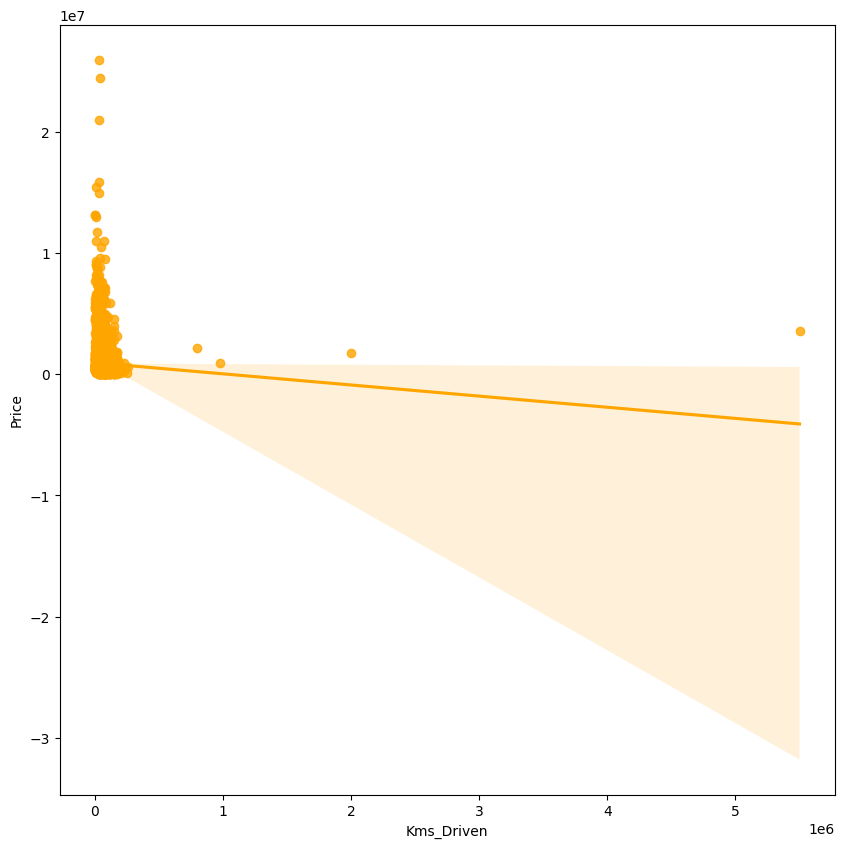

In [66]:
plt.figure(figsize=(10,10))
sns.regplot(data=df_final, x='Kms_Driven', y='Price',color='orange')
plt.show()

<Figure size 1000x1000 with 0 Axes>

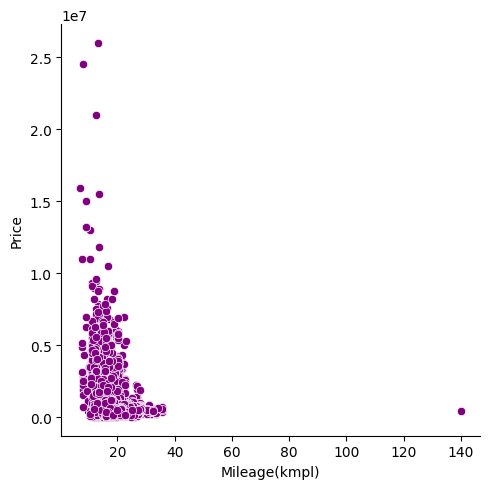

In [61]:
plt.figure(figsize=(10,10))
sns.relplot(data=df_final, x='Mileage(kmpl)', y='Price',color='purple')
plt.show()

Conclusions from the above plot:
1. From the above analysis it seams that as the km_driven increases Price o the car decreases.
2. selling price and mileage are directly proportional as expected
3. number of owner is inversely proportional tot he price
4. Automatic car is costlier than manual car but the number of manual car is more than automatic one.
5. New cars seels at higher price




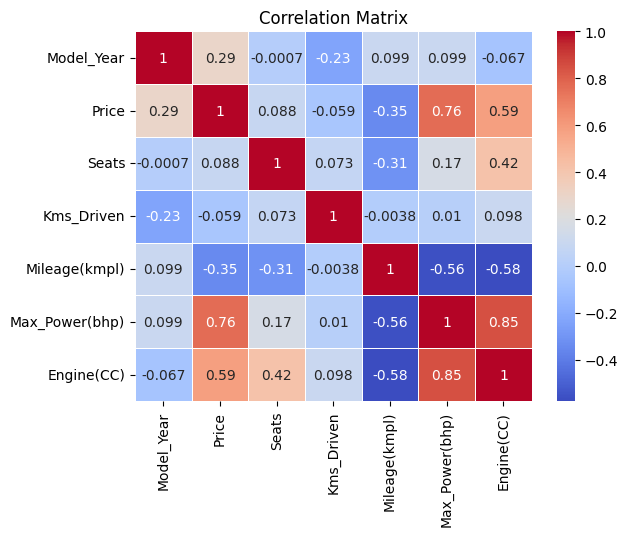

In [126]:
numeric_columns = ['Model_Year', 'Price', 'Seats', 'Kms_Driven', 'Mileage(kmpl)', 'Max_Power(bhp)', 'Engine(CC)']
correlation_matrix = df_final[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()


In [151]:
df_final.head(2)

,city,Fuel_Type,Transmission,OEM,Model,Model_Year,Price,Seats,Kms_Driven,Ownership,Mileage(kmpl),Max_Power(bhp),Engine(CC),Top_3_Features,Top_3_Features_Encoded,OEM_Encoded
0,Bangalore,Petrol,0,Maruti,Maruti Celerio,2015,400000.0,5.0,120000.0,Third Owner,23.1,67.04,998.0,"Power Steering, Power Windows Front, Air Condi...",931663.96007,509677.447118
1,Bangalore,Petrol,0,Ford,Ford Ecosport,2018,811000.0,5.0,32706.0,Second Owner,17.0,121.31,1497.0,"Power Steering, Power Windows Front, Air Condi...",931663.96007,739217.821782


Encoding categorical column

In [127]:
#categorical_columns
category_columns = ['city','Fuel_Type','Transmission','OEM','Model','Ownership','Top_3_Features']
df_final[category_columns].nunique()

city                6
Fuel_Type           5
Transmission        2
OEM                31
Model             272
Ownership           5
Top_3_Features     41
dtype: int64

In [128]:
# ownership and fuel type one-hot-encoding
ownership_ohe = pd.get_dummies(df_final['Ownership'])
city_ohe = pd.get_dummies(df_final['city'])
fuel_ohe = pd.get_dummies(df_final['Fuel_Type'])

df_final['Transmission'] = df_final['Transmission'].map({'Manual': 0, 'Automatic': 1})

In [129]:
# Assuming 'Top_3_Features' is the column with 41 unique values. we will use target encoding
mean_price_y_features = df_final.groupby('Top_3_Features')['Price'].mean()
df_final['Top_3_Features_Encoded'] = df_final['Top_3_Features'].map(mean_price_y_features)

# Assuming 'OEM' is the column with 31 unique values
mean_price_y_oem = df_final.groupby('OEM')['Price'].mean()
df_final['OEM_Encoded'] = df_final['OEM'].map(mean_price_y_oem)



In [130]:
# adding encoded variables to the dataset and dropping Model because of too many unique values
df_model=df_final.drop(columns=['city','Fuel_Type','Ownership','Model','Top_3_Features','OEM'], axis=1)
df_model = pd.concat([df_model, ownership_ohe, fuel_ohe, city_ohe], axis=1)

In [131]:
df_model.head(2)

,Transmission,Model_Year,Price,Seats,Kms_Driven,Mileage(kmpl),Max_Power(bhp),Engine(CC),Top_3_Features_Encoded,OEM_Encoded,...,Diesel,Electric,LPG,Petrol,Bangalore,Chennai,Delhi,Hyderabad,Jaipur,Kolkata
0,0,2015,400000.0,5.0,120000.0,23.1,67.04,998.0,931663.96007,509677.447118,...,False,False,False,True,True,False,False,False,False,False
1,0,2018,811000.0,5.0,32706.0,17.0,121.31,1497.0,931663.96007,739217.821782,...,False,False,False,True,True,False,False,False,False,False


In [152]:
#df_model.to_csv('encoded_dataset.csv', index=False)


In [132]:
df_model.columns

Index(['Transmission', 'Model_Year', 'Price', 'Seats', 'Kms_Driven',
       'Mileage(kmpl)', 'Max_Power(bhp)', 'Engine(CC)',
       'Top_3_Features_Encoded', 'OEM_Encoded', 'Fifth Owner', 'First Owner',
       'Fourth Owner', 'Second Owner', 'Third Owner', 'CNG', 'Diesel',
       'Electric', 'LPG', 'Petrol', 'Bangalore', 'Chennai', 'Delhi',
       'Hyderabad', 'Jaipur', 'Kolkata'],
      dtype='object')

In [134]:
X = df_model.drop('Price', axis=1)
y = df_model['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [137]:
# Model-1 ---> Linear Regression
model1 = LinearRegression()
model1.fit(X_train, y_train)
preds = model1.predict(X_test)

# Evaluatio metrics
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, preds)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)

Mean Absolute Error (MAE): 311530.5692924904
Mean Squared Error (MSE): 401591229505.37836
Root Mean Squared Error (RMSE): 633712.2608135164
R-squared (R2): 0.7017020877706881


In [141]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, y_train)

pred_rf = model_rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, pred_rf)
mse_rf = mean_squared_error(y_test, pred_rf)
r2_rf = r2_score(y_test, pred_rf)

print(f"Mean Absolute Error (MAE): {mae_rf}")
print(f"Mean Squared Error (MSE): {mse_rf}")
print(f"R-squared (R2): {r2_rf}")

Mean Absolute Error (MAE): 138602.29172086227
Mean Squared Error (MSE): 199469014394.38284
R-squared (R2): 0.8518364292428202


In [142]:
from sklearn.ensemble import GradientBoostingRegressor
model_gb = GradientBoostingRegressor()
model_gb.fit(X_train, y_train)
preds_gb = model_gb.predict(X_test)

mae_gb = mean_absolute_error(y_test, preds_gb)
mse_gb = mean_squared_error(y_test, preds_gb)
r2_gb = r2_score(y_test, preds_gb)

print(f"Mean Absolute Error (MAE): {mae_gb}")
print(f"Mean Squared Error (MSE): {mse_gb}")
print(f"R-squared (R2): {r2_gb}")

Mean Absolute Error (MAE): 159292.7830515388
Mean Squared Error (MSE): 179283892377.9353
R-squared (R2): 0.8668297341589066


In [150]:
# lets save the best model
import pickle
import joblib
joblib.dump(model_gb, 'gradient_boosting_model.pkl')

['gradient_boosting_model.pkl']

# CONCLUSION
After trying few models we conclude that GradientBoosingRegressor outperformed other models with evaluation metrics as-
Mean Absolute Error (MAE): 159292.7830515388
Mean Squared Error (MSE): 179283892377.9353
R-squared (R2): 0.8668297341589066

# Room for improvement
1. skeweness could have been handled better.
2. top_features column could have been handled better.
3. feature engineering can be done on some columns.